IMPORT LIBRARY

In [3]:
import sys, os
current_dir = os.getcwd()
project_root = current_dir[:current_dir.find("src") - 1]
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from models import Random_Forest, Linear
from src.root import get_root

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

e:\univercity\project\Bargh_ML\logs\data_selector.log
e:\univercity\project\Bargh_ML\logs\feature_modifier.log
e:\univercity\project\Bargh_ML\logs\models.log
e:\univercity\project\Bargh_ML\logs\model_main.log


In [4]:
def filter_time(df,date1,date2,get_bool=False):
    if get_bool:
        return (df['datetime'] >= date1) & (df['datetime'] <= date2)
    return df[(df['datetime'] >= date1) & (df['datetime'] <= date2)]

def filter_name_code(df,name,code,get_bool=False):
    if get_bool:
        return (df["name"] == name) & (df["code"] == code)
    return df[(df["name"] == name) & (df["code"] == code)]

def get_interval(df,l_min):
    df_s = df.reset_index(drop=True)
    diff = df_s['datetime'].diff()  # محاسبه اختلاف زمانی بین ردیف ها
    gap_mask = diff != pd.Timedelta(hours=1)  # هر جایی اختلاف دقیقاً 1 ساعت نیست، مرز بازه جدید است
    # ایندکس شروع بازه‌ها
    start_indices = df_s.index[gap_mask].tolist()
    # چون اولین ایندکس هم ابتدای یک بازه است، اگر نیست اضافه می‌کنیم
    if 0 not in start_indices:
        start_indices = [0] + start_indices
    # ایندکس پایان بازه‌ها یکی قبل از شروع بازه بعدی است
    end_indices = [i-1 for i in start_indices[1:]] + [df_s.index[-1]]
    
    for i in range(len(start_indices)-1,-1,-1):
        if end_indices[i] - start_indices[i] < l_min-1:
            end_indices.pop(i)
            start_indices.pop(i)
    # ساخت لیست بازه‌های (i1, i2)
    index_ranges = list(zip(start_indices, end_indices))
    
    # ساخت لیست بازه‌های زمانی (t1, t2)
    time_ranges = [(df_s.loc[i1, 'datetime'], df_s.loc[i2, 'datetime']) for i1, i2 in index_ranges]
    return index_ranges,time_ranges

import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def is_smooth_array(data,threshold,f_show = False):
    x = data["datetime"].to_numpy()  # Your x-values
    y = data["generation"].to_numpy()  # Your y-values
    window_length = len(y) - 1 + len(y)%2  # window size, must be odd, adjust for your data
    
    polyorder = 2  # polynomial order
    y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)

    # Compute residual noise
    residuals = y - y_smooth
    noise_std = np.std(residuals)
    value = np.var(np.diff(y, n=1))#abs(y-y.mean())#residuals
    
    # Optional: Visualize
    if f_show:
        plt.plot(x, y, label='Raw data')
        plt.plot(x, y_smooth, label='Smoothed curve')
        plt.legend()
        plt.show()

    if noise_std < threshold:  # threshold is your chosen value for smoothness
        return noise_std,True,value
    else:
        return noise_std,False,value

def is_smooth(df,date1,date2,data_var,data_date,threshold,flag=False):
    slice = filter_time(df,date1,date2)[["hour","generation","datetime"]]
    if len(slice["hour"]) >= 8:
        x,f,re = is_smooth_array(slice,threshold,flag)
        if data_var != None : data_var[f].append(x)
        if data_date != None : data_date[f].append((date1,date2))
        if f:    
            return 1,1
        return 1,0
    return 0,0

def get_smooth_good_slice(df,time_ranges,threshold):
    data_var = {True:[],False:[]}
    data_date = {True:[],False:[]}
    t = 0
    n = 0
    for date1,date2 in time_ranges:
        nn,tt = is_smooth(df,date1,date2,data_var,data_date,threshold)
        n += nn
        t += tt
    p = t/n*100 if n != 0 else None
    return p,data_var,data_date

def labeling_point(df,df_n_c,date,label):
    for date1,date2 in date:
        flag_array = filter_time(df_n_c,date1,date2,get_bool=True)
        df.loc[flag_array.index[flag_array],"is_good_pick"] = label

In [12]:
df_row = pd.read_csv(get_root() +"/data/processed/integrated.csv", encoding='utf-8')
df_modified = df_row[["name","code","date","hour","status",'value',"generation"]].copy(deep=True)

feature_adder = Feature_adder(df_modified)
feature_adder.add_season()
df_modified = Data_selector(df_modified).select(m_in_summer=True)

threshold = 2

df_modified['datetime'] = df_modified['date'] + pd.to_timedelta(df_row['hour'], unit='h')

power_plants = df_modified[['name', 'code']].drop_duplicates()
print(len(power_plants))

name = "پرند"
code = "S1"

df_name_code_smooth = filter_name_code(df_modified,name,code)

index_ranges,time_ranges = get_interval(df_name_code_smooth,l_min=4)
#print(k,"->",np.unique(np.array([(t2-t1).total_seconds()/3600+1 for t1,t2 in time_ranges]),return_counts=True))
p,data_var,data_date = get_smooth_good_slice(df=df_name_code_smooth,time_ranges=time_ranges,threshold=threshold)
print("**********")
print(name,code)
print(p,len(data_date[True]),len(data_date[False]))
print("->",np.unique(np.array([(t2-t1).total_seconds()/3600+1 for t1,t2 in time_ranges]),return_counts=True))        

103
**********
پرند S1
0.0 0 175
-> (array([ 4.,  5., 13., 16., 17., 18.]), array([ 75,  41,   1,   6,   1, 167], dtype=int64))


207618

C:\Users\alireza\AppData\Roaming\Python\Python310\site-packages\matplotlib\axes\_axes.py:7101: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\alireza\AppData\Roaming\Python\Python310\site-packages\matplotlib\axes\_axes.py:7102: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

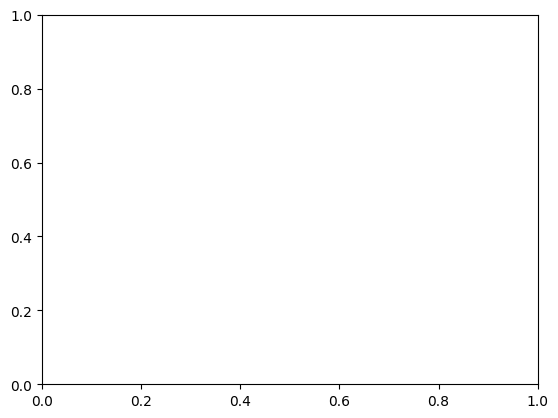

In [11]:
plt.hist(data_var[True]+data_var[False], bins=40, color='skyblue', edgecolor='black')
plt.show()
plt.hist(data_var[True], bins=40, color='skyblue', edgecolor='black')
plt.show()
plt.hist(data_var[False], bins=40, color='skyblue', edgecolor='black')
plt.show()

In [117]:
print(np.count_nonzero(df_only["is_good_pick"].to_numpy() == 2))

6364


In [118]:
print(len(data_date[False]),len(data_date[True]))
print(sum((m2-m1).total_seconds()/3600+1 for (m1,m2) in data_date[True]))
print(sum((m2-m1).total_seconds()/3600+1 for (m1,m2) in data_date[False]))

13 354
6364.0
234.0


In [119]:
df_only.to_csv(path_or_buf=get_root() +'/data/processed/prediction_only.csv', sep=',', header=True, index=False,na_rep='NULL')

RUN MODEL

In [133]:
import sys, os
current_dir = os.getcwd()
project_root = current_dir[:current_dir.find("src") - 1]
sys.path.insert(0, project_root)

import pandas as pd
from data_selector import Data_selector
from feature_modifier import Feature_selector, Feature_adder
from logs.logger import CustomLogger
from src.models.models import Random_Forest, Linear, Polynomial, XGBoost

logger = CustomLogger(name="model_main", log_file_name='model_main.log').get_logger()

csv_path = os.path.join(project_root, "data", "processed", "prediction_only.csv")
df = pd.read_csv(csv_path, encoding='utf-8')
df = filter_name_code(df,"پرند","G11")
#print()
df = df.drop(columns=['name','code'],axis=1)
logger.info(f"Csv file has bean read successfully")

feature_adder = Feature_adder(df)
feature_adder.add_season()
# feature_adder.create_feature_with_delay("temperature", 1)
# feature_adder.create_feature_with_delay("temperature", 2)
# feature_adder.create_feature_with_delay("temperature", 3)
logger.info(f"Some features have been added successfully")

df_modified = df[df["is_good_pick"] == 2]
logger.info(f"Rows have been selected successfully")

feature_selector = Feature_selector(df_modified, "generation")
feature_to_be_dropped = ['id', 'date', 'declare', 'require', 'dew', 'apparent_temperature', 'rain', 'snow',
                            'evapotransporation', 'wind_direction']


X, y = feature_selector.select(feature_to_be_dropped)
logger.info(f"Some features have been dropped successfully")

2025-08-18 16:07:08 - model_main - INFO - Csv file has bean read successfully
2025-08-18 16:07:08 - model_main - INFO - Some features have been added successfully
2025-08-18 16:07:08 - model_main - INFO - Rows have been selected successfully
e:\univercity\project\Bargh_ML\src\models\feature_modifier.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if features_to_drop is not None:
2025-08-18 16:07:08 - model_main - INFO - Some features have been dropped successfully


In [ ]:
n_est = 40 # 40
depth = 100 # 22
model = Random_Forest()
model.scale_and_split_data(X, y)

train_err = []
test_err = []
for i in range(1,depth+1): 
    model.fit(n_estimators=n_est, max_depth=i)
    mse_train_actual, mse_test_actual = model.compute_mse_error()
    print("depth",i,f"Train Error: {mse_train_actual:0.2f}%",f"Test Error: {mse_test_actual:0.2f}%")
    train_err.append(mse_train_actual)
    test_err.append(mse_test_actual)


depth 1 Train Error: 3.23% Test Error: 3.36%
depth 2 Train Error: 2.95% Test Error: 3.05%
depth 3 Train Error: 2.76% Test Error: 2.86%


In [ ]:
df.columns

Index(['id', 'name', 'code', 'date', 'hour', 'temperature', 'humidity', 'dew',
       'apparent_temperature', 'precipitation', 'rain', 'snow',
       'surface_pressure', 'evapotransporation', 'wind_speed',
       'wind_direction', 'value', 'forecast', 'generation', 'declare',
       'status', 'require', 'datetime', 'is_good_pick', 'season'],
      dtype='object')

Find Match

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def dot_vectors(pick_df,tmep_df):
    a1 = pick_df.to_numpy()
    a2 = tmep_df.to_numpy()
    lv = []
    m1 = np.mean(a1)
    n1 = len(a1)
    n2 = len(a2)
    for i in range(0,n2-n1):
        m2 = np.mean(a2[-(i+1):-(i+n1):-1])
        lv.append(sum(  (a1[-(k+1)]-m1)  *  (a2[-(i+k+1)]-m2) for k in range(n1)))
    return np.array(lv)

def get_dphase(df,t1s,t2s,flag=False):
    t1 = pd.to_datetime(t1s)
    t2 = pd.to_datetime(t2s)
    t0 = t1 - np.timedelta64(12,'h')
    pick_df = filter_time(df,t1,t2)["generation"]
    tmep_df = filter_time(df,t0,t2)["temperature"]
    n = len(tmep_df)-len(pick_df)
    lv = dot_vectors(pick_df,tmep_df)
    
    time = np.arange(0,n)
    if flag:
        plt.plot(time,lv)
        plt.show()
    return lv

def get_for_alltime(df,times_pick): 
    d_get_dphase = []
    for s1,s2 in times_pick:
        d_get_dphase.append(get_dphase(df,s1,s2).argmin())#(s1,s2)
    return d_get_dphase

In [ ]:
times_pick = [(date + np.timedelta64(14,'h'),date + np.timedelta64(22,'h') ) for date in df_name_code["date"].unique()]
d_get_dphase = get_for_alltime(df_name_code,times_pick)

In [ ]:
a,b = np.unique(np.array(d_get_dphase), return_counts=True)
for i in range(len(a)):
   print(a[i],b[i])

0 252
1 160
2 255
3 235
4 142
5 72
6 31
7 12
8 10
9 19
10 48
11 224
35 1
